# LRG Templates

John Moustakas  
Siena College  
2018 October 5


The goal of this notebook is to use observations of a large number of luminous red galaxies (LRGs) with DECaLS/DR7 *grzW1W2* photometry and ancillary spectroscopic redshifts to generate a set of spectroscopic templates suitable for spectroscopic simulations, targeting investigations, and other DESI-related projects.

The parent sample consists of 111,114 LRGs selected by **Rongpu Zhou (Pittsburgh)** with spectroscopic redshifts from SDSS/Main, (e)BOSS, AGES, DEEP2, GAMA, OzDES, VIPERS, VVDS, and COSMOS (precise medium-band photometric redshifts).  

We cull this sample to 75,315 LRGs by applying the following additional cuts:
* 0.2 < z < 1.2
* nobs_[g,r,z] >= 3
* wisemask == False
* brightstarinblob == False
* measured flux in all five *grzW1W2* bands

To ensure this sample is representative of the parent sample of >3.3M LRGs with precise photometric redshifts, we count the number of photometric LRGs near each LRG with a spectroscopic redshift (in *redshift-apparent magnitude-color* space) and use this below as a statistical weight.

With this sample in hand, we generate spectral templates using the following procedure:
  1. We use the Bayesian spectral energy distribution (SED) modeling code [iSEDfit](http://www.sos.siena.edu/~jmoustakas/isedfit) and the CKC14z simple stellar population models of Conroy et al. to model the observed SEDs of the parent sample of galaxies.  The outputs of this code are the best-fitting (maximum likelihood) spectroscopic template and the marginalized posterior distributions on a large number of quantities of interest, stored in the file `legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits`.  
  
  In addition, we compute K-corrected absolute magnitudes in the DECaLS and BASS+MzLS *g*-, *r*-, and *z*-band bandpasses and store them in the file `legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits`.  The code that generates these files is [desi_legacysurvey_lrg_isedfit](https://github.com/moustakas/moustakas-projects/blob/master/desi/templates/desi_legacysurvey_lrg_isedfit.pro).
  
  
  2. Next, the notebook below documents how we select a "representative" subset of these galaxies to serve as our LRG template set.
  
  
  3. Finally, we generate the templates themselves using the IDL script [build_lrg_basis_templates](https://desi.lbl.gov/svn/docs/technotes/spectro/lrg-templates/trunk/pro/build_lrg_basis_templates).  
 

In [1]:
import os
import numpy as np

from astropy.table import Table, hstack
from scipy.spatial import cKDTree as KDTree

In [2]:
import matplotlib.pyplot as plt
from corner import corner

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

### Establish the random and pathnames.

In [4]:
seed = 123
rand = np.random.RandomState(seed)

In [5]:
isedfit_version = 'v2.0'
templates_version = 'v2.1'

In [6]:
isedfit_dir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'templates', 'lrg_templates', 'isedfit', isedfit_version)

In [7]:
metadata_outfile = os.path.join(isedfit_dir, 'lrg-templates-isedfit-{}.fits'.format(isedfit_version))

### Read the iSEDfit and absolute magnitude catalogs.

In [8]:
def read_isedfit():
    """Read the iSEDfit fitting results."""
    
    parentfile = os.path.join(isedfit_dir, 'lrg_parent.fits.gz')
    isedfile = os.path.join(isedfit_dir, 'legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz')
    kcorrfile = os.path.join(isedfit_dir, 'legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz')

    print('Reading {}'.format(parentfile))
    parent = Table.read(parentfile)
    print('Reading {}'.format(isedfile))
    ised = Table.read(isedfile)
    print('Reading {}'.format(kcorrfile))
    kcorr = Table.read(kcorrfile)
    
    snrmin = 3.0
    chi2min = 10
    
    keep = np.where(
        (ised['CHI2'] < chi2min) * 
        (np.sum(ised['MAGGIES'] * np.sqrt(ised['IVARMAGGIES']) > snrmin, axis=1) == 5)
    )[0]
    print('Read {} galaxies with chi2 < {} and S/N > {} in all 5 photometric bands.'.format(
        len(keep), chi2min, snrmin))
    
    cat = dict()
    cat['weight'] = len(keep) * parent['COUNT'][keep].data / np.sum(parent['COUNT'][keep].data)
    cat['redshift'] = kcorr['Z'][keep].data
    cat['Mstar'] = ised['MSTAR_50'][keep].data
    cat['Mg'] = kcorr['ABSMAG'][keep, 0].data
    cat['Mr'] = kcorr['ABSMAG'][keep, 1].data
    cat['Mz'] = kcorr['ABSMAG'][keep, 2].data
    cat['gr'] = cat['Mg'] - cat['Mr']
    cat['rz'] = cat['Mr'] - cat['Mz']

    with np.errstate(invalid='ignore'):
        cat['grobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 0].data / ised['MAGGIES'][keep, 1].data )
        cat['rzobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 1].data / ised['MAGGIES'][keep, 2].data )
        cat['zW1obs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 2].data / ised['MAGGIES'][keep, 3].data )
     
    #mm = - 2.5 * np.log10(ised['MAGGIES'][keep, 0].data)
    #_ = plt.hist(mm, bins=100)
    
    kcorr.remove_columns(['Z', 'ISEDFIT_ID', 'MAGGIES', 'IVARMAGGIES'])
    out = hstack([ised[keep], kcorr[keep]])
    
    return cat, out

In [9]:
cat, ised = read_isedfit()
ngal = len(ised)

Reading /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v2.0/lrg_parent.fits.gz
Reading /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v2.0/legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz
Reading /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v2.0/legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz
Read 48817 galaxies with chi2 < 10 and S/N > 3.0 in all 5 photometric bands.


In [10]:
print(sorted(cat.keys()))

['Mg', 'Mr', 'Mstar', 'Mz', 'gr', 'grobs', 'redshift', 'rz', 'rzobs', 'weight', 'zW1obs']


In [11]:
ised[:2]

ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],BESTMAGGIES [5],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2_1,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST,DTBURST,FBURST,MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR,CHI2_2,FLAM_1500,CFLUX_3727,KCORRECT [3],ABSMAG [3],IVARABSMAG [3],SYNTH_ABSMAG [3],ABSMAG_FILTERLIST [3]
int32,float64,float64,float32,float32,float32,float32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes11
0,145.9106933214981,-0.6699389037163556,0.36925668,5.069725e-09 .. 7.102788e-08,2.0459266e+20 .. 3.567438e+17,5.123763e-09 .. 7.3073075e-08,0,89,1,1,9.932455,337586130000.0,987901400.0,11.324967,5.3718367,4.2783546,0.54821414,0.02679053,0.100780115,0.26123187,-1.0,52.577934,-0.47493076,-1.4258919,-3.224153,-2.8096416,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.325342,5.3718367,4.2783546,0.4294942,0.02679053,0.100780115,0.26123187,-1.0,-0.47455597,-1.4255171,-3.224153,-2.8096416,-1.0,-1.0,-1.0,11.323991,5.233574,4.3763967,0.42961803,0.023551058,0.2524198,0.3406924,-1.0,-1.4260209,-2.2226713,-5.2463737,-4.7529306,-1.0,-1.0,-1.0,0.043910265,0.6299818,0.622634,0.14963765,0.0028223568,0.2235998,0.17169169,0.0,0.8827634,0.66050625,3.0806031,3.1653714,0.0,0.0,0.0,9.932455,8.01557e-18,3.4443556e-17,-0.25023428 .. 0.10797201,-22.282818 .. -23.524279,35804.156 .. 41486.633,-22.2573 .. -23.544544,decam_g.par .. decam_z.par
1,145.26691496916993,-0.957322907766804,0.40593767,3.6528445e-09 .. 5.560954e-08,3.4718932e+20 .. 3.883426e+17,3.854969e-09 .. 5.622779e-08,0,622,1,1,7.9159555,456607100000.0,1268900500.0,11.4445305,7.928177,6.6888046,0.61982894,0.01642725,0.32547173,0.19406769,-1.0,52.102215,-1.5808468,-2.6522436,-4.412614,-4.0516644,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.447929,7.239101,6.6888046,0.24460986,0.016303929,0.27576527,0.2542269,-1.0,-3.3289576,-3.3289576,-11.289713,-10.224919,-1.0,-1.0,-1.0,11.446054,7.35516,6.6061816,0.3745679,0.0161881,0.293007,0.2579056,-1.0,-2.5812752,-3.0376954,-9.357711,-8.683728,-1.0,-1.0,-1.0,0.013717651,0.6013062,0.30918682,0.14706184,0.0007599038,0.07265896,0.07223167,0.0,0.50515914,0.24282217,2.705914,2.8007746,0.0,0.0,0.0,7.9159555,1.4474227e-18,2.9058928e-17,-0.19238524 .. 0.09691145,-22.286253 .. -23.52724,41834.586 .. 52586.44,-22.2679 .. -23.537163,decam_g.par .. decam_z.par


### Visualize the sample in the rest-frame and the observed frame.

In [12]:
zlim, Mrlim, grlim, rzlim = (0.2, 1.1), (-21, -25), (0.2, 1.2), (0.2, 0.8)

In [13]:
def qa_rest():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1.hexbin(cat['redshift'], cat['Mr'], mincnt=1, bins='log', 
               C=cat['weight'], reduce_C_function=np.sum,
               cmap=plt.cm.get_cmap('RdYlBu'))
    ax1.set_ylim(Mrlim)
    ax1.set_xlim(zlim)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel(r'$M_{0.0r}$')
    
    ax2.hexbin(cat['redshift'], cat['gr'], mincnt=1, bins='log', 
               C=cat['weight'], reduce_C_function=np.sum,           
               cmap=plt.cm.get_cmap('RdYlBu'))
    ax2.set_xlim(zlim)
    ax2.set_ylim(grlim)
    ax2.set_xlabel('Redshift')
    ax2.set_ylabel(r'$^{0.0}(g - r)$')
    
    ax3.hexbin(cat['rz'], cat['gr'], mincnt=1, bins='log', 
               C=cat['weight'], reduce_C_function=np.sum,               
               cmap=plt.cm.get_cmap('RdYlBu'))
    ax3.set_xlabel(r'$^{0.0}(r - z)$')
    ax3.set_ylabel(r'$^{0.0}(g - r)$')
    ax3.set_ylim(grlim)
    ax3.set_xlim(rzlim)
    
    hb = ax4.hexbin(cat['Mr'], cat['gr'], mincnt=1, bins='log', 
                    C=cat['weight'], reduce_C_function=np.sum,                    
                    cmap=plt.cm.get_cmap('RdYlBu'))
    ax4.set_xlabel(r'$M_{0.0r}$')
    ax4.set_ylabel(r'$^{0.0}(g - r)$')
    ax4.set_xlim(Mrlim)
    ax4.set_ylim(grlim)
   
    cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(hb, cax=cax, label=r'$\log_{10}$ (Weighted Number of Galaxies)')

    for aa in (ax1, ax2, ax3, ax4):
        aa.grid(True)
    
    plt.subplots_adjust(wspace=0.2, right=0.85)

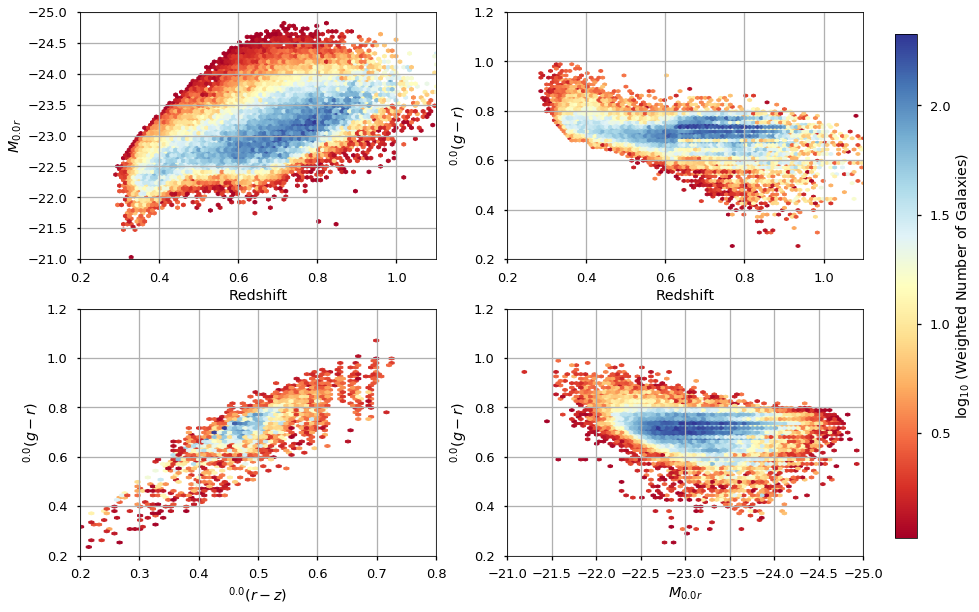

In [14]:
qa_rest()

#### Now let's look at observed color-color space.

In [15]:
grobslim, rzobslim = (0.5, 3), (0.8, 2.2)

In [16]:
def qa_obs():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hexbin(cat['rzobs'], cat['grobs'], mincnt=1, bins='log', 
               C=cat['weight'], reduce_C_function=np.sum,
               cmap=plt.cm.get_cmap('RdYlBu'))
    ax1.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax1.set_ylabel(r'$(g - r)_{\rm obs}$')
    
    hb = ax2.hexbin(cat['rzobs'], cat['zW1obs'], mincnt=1, bins='log', 
                    C=cat['weight'], reduce_C_function=np.sum,                    
                    cmap=plt.cm.get_cmap('RdYlBu'))
    cb = plt.colorbar(hb)
    cb.set_label(r'$\log_{10}$ (Number of Galaxies)')

    ax2.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax2.set_xlabel(r'$(z - W1)_{\rm obs}$')
    ax1.set_xlim(0.7, 2.3)
    ax1.set_ylim(0.3, 3.0)
    ax2.set_xlim(0.7, 2.3)
    ax2.set_ylim(0.2, 2.5)
    
    for aa in (ax1, ax2):
        aa.grid(True)

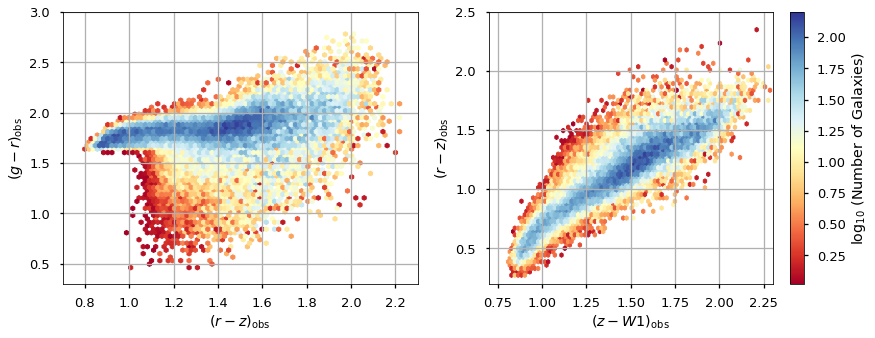

In [17]:
qa_obs()

### Choose N templates with probability equal to the statistical weight.

The question is: what minimum set templates can be used to *describe* this population of LRGs. This problem is NP hard, although there are methods for solving it (see, e.g., the [SetCoverPy](https://github.com/guangtunbenzhu/SetCoverPy) algorithm).  

Here we simply choose the desired number of templates and choose them with probability equal to the (known) statistical weight.

In [18]:
ntemplates = 3000

In [19]:
iarch = rand.choice(ngal, ntemplates, p=cat['weight']/np.sum(cat['weight']))
resp = ngal * cat['weight'] / np.sum(cat['weight'])
print('Selected {} templates from {} galaxies.'.format(ntemplates, ngal))

Selected 3000 templates from 48817 galaxies.


### Visualize the results.

In [20]:
def _markers():
    size = 50 * (1+(resp - resp.min()) / resp.ptp())
    shade = (cat['gr'][iarch] - cat['gr'][iarch].min()) / cat['gr'][iarch].ptp()
    col = plt.cm.coolwarm(shade)
    return size, col

In [21]:
def qa_templates():
    """Generate a color-color plot with the symbol size scaled by the responsibility.
    
    """
    
    size, col = _markers()
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))

    ax1.scatter(cat['rzobs'], cat['grobs'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax1.scatter(cat['rzobs'][iarch], cat['grobs'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax1.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax1.set_ylabel(r'$(g - r)_{\rm obs}$')

    ax2.scatter(cat['zW1obs'], cat['rzobs'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax2.scatter(cat['zW1obs'][iarch], cat['rzobs'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax2.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax2.set_xlabel(r'$(z - W1)_{\rm obs}$')

    ax3.scatter(cat['rz'], cat['gr'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax3.scatter(cat['rz'][iarch], cat['gr'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax3.set_xlabel(r'$^{0.0}(r - z)$')
    ax3.set_ylabel(r'$^{0.0}(g - r)$')
    ax3.set_ylim(grlim)
    ax3.set_xlim(rzlim)
    
    ax4.scatter(cat['Mr'], cat['gr'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax4.scatter(cat['Mr'][iarch], cat['gr'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax4.set_xlabel(r'$M_{0.0r}$')
    ax4.set_ylabel(r'$^{0.0}(g - r)$')
    ax4.set_xlim(Mrlim)
    ax4.set_ylim(grlim)
    
    ax5.scatter(cat['redshift'], cat['Mr'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax5.scatter(cat['redshift'][iarch], cat['Mr'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax5.set_xlabel('Redshift')
    ax5.set_ylabel(r'$M_{0.0r}$')
    ax5.set_xlim(zlim)
    ax5.set_ylim(Mrlim)

    ax6.scatter(cat['redshift'], cat['gr'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax6.scatter(cat['redshift'][iarch], cat['gr'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax6.set_xlabel('Redshift')
    ax6.set_ylabel(r'$^{0.0}(g - r)$')
    ax6.set_xlim(zlim)
    ax6.set_ylim(grlim)
    
    for aa in (ax1, ax2, ax3, ax4, ax5, ax6):
        aa.grid(True)    
    
    fig.subplots_adjust(wspace=0.2, hspace=0.3)

#### Symbol size is proportional to "responsibility" (*nperbin*) and color is proportional to rest-frame g-r color.

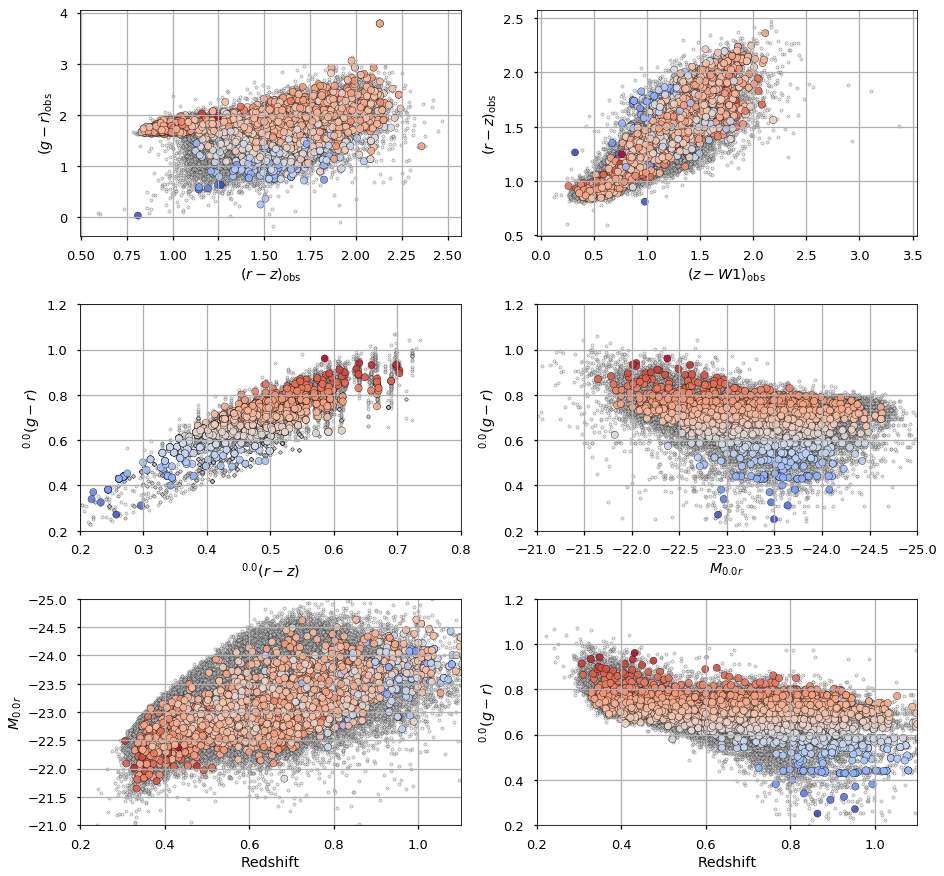

In [22]:
qa_templates()

#### Some additional diagnostics of the templates.

*SFR100* is the star formation rate (SFR) averaged over the previous 100 Myr.  Note that templates with higher SFRs are somewhat over-represented in the template set because we choose templates with equal probability, not weighted by the number of galaxies in each cell.

In [23]:
def qa_template_properties():
    size, col = _markers()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    ax1.hist(ised['MSTAR_50'], weights=cat['weight'], density=True, bins=30, label='Full Sample')
    ax1.hist(ised['MSTAR_50'][iarch], density=True, bins=30, alpha=0.5,
            label='Templates')
    ax1.set_xlabel(r'$\log_{10}\ (M\ /\ M_{\odot})$')
    ax1.set_ylabel('Relative Fraction')
    ax1.set_xlim((10, 12.5))
    ax1.yaxis.set_ticks([])
    
    ax2.hist(ised['SFR100_50'], weights=cat['weight'], density=True, bins=30, label='Full Sample')
    ax2.hist(ised['SFR100_50'][iarch], density=True, bins=30, alpha=0.5,
            label='Templates')    
    ax2.set_xlabel(r'$\log_{10}\ (SFR_{100}\ /\ M_{\odot}\ {\rm yr}^{-1})$')
    ax2.set_xlim((-4.5, 2))
    ax2.yaxis.set_ticks([])
    ax2.legend(loc='upper right')
    
    ax3.scatter(cat['redshift'], ised['MSTAR_50'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax3.scatter(cat['redshift'][iarch], ised['MSTAR_50'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax3.set_xlabel('Redshift')
    ax3.set_ylabel(r'$\log_{10}\ (M\ /\ M_{\odot})$')
    ax3.set_xlim(zlim)
    ax3.set_ylim((10, 12.5))

    ax4.scatter(cat['redshift'], ised['SFR100_50'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax4.scatter(cat['redshift'][iarch], ised['SFR100_50'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax4.set_xlabel('Redshift')
    ax4.set_ylabel(r'$\log_{10}\ (SFR_{100}\ /\ M_{\odot}\ {\rm yr}^{-1})$')
    ax4.set_xlim(zlim)
    ax4.set_ylim((-4.5, 2))
    
    plt.subplots_adjust(wspace=0.25, hspace=0.2)

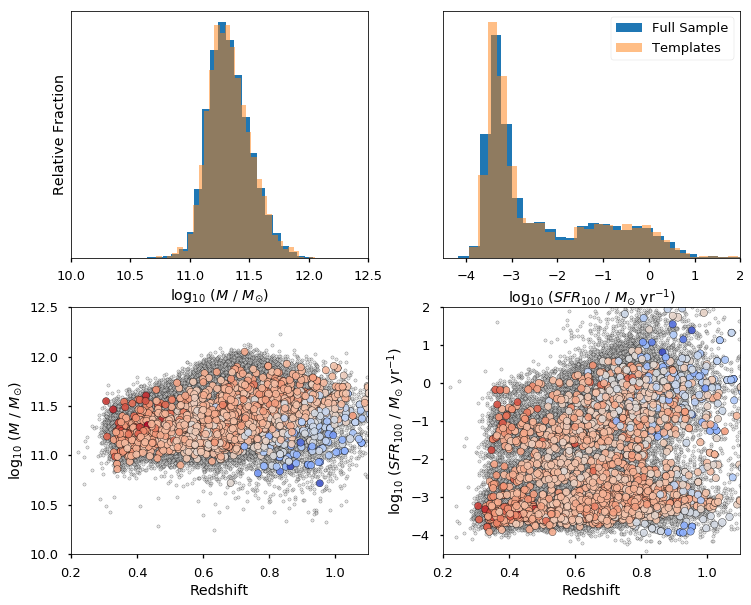

In [24]:
qa_template_properties()

### Write out the metadata.

In [25]:
print('Writing {}'.format(metadata_outfile))
ised[iarch].write(metadata_outfile, overwrite=True)

Writing /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v2.0/lrg-templates-isedfit-v2.0.fits


### Visualize the resulting templates.

The spectra have to built in IDL using the script [build_lrg_basis_templates](https://desi.lbl.gov/svn/docs/technotes/spectro/lrg-templates/trunk/pro/build_lrg_basis_templates), which we assume has happend.

In [26]:
from desisim.io import read_basis_templates

In [27]:
flux, wave, meta = read_basis_templates('LRG')
nt = len(meta)
print('Number of templates = {}'.format(nt))

INFO:io.py:945:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v3.0/lrg_templates_v2.1.fits
Number of templates = 3000


In [28]:
meta

TEMPLATEID,ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],DECAM_G,DECAM_R,DECAM_Z,BASS_G,BASS_R,MZLS_Z,W1,W2,LOGMSTAR,LOGSFR,LOGSFR100,AV_ISM,AGE,SFRAGE,HBETA_CONTINUUM,D4000
int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,14308,317.2875834003553,0.9152070955793059,0.57553643,7.972503e-10 .. 2.000799e-08,8.7857446e+20 .. 4.830902e+17,22.669,20.933823,19.590668,22.740288,20.96191,19.58329,18.637753,19.155605,11.211722,-2.167968,-2.8001888,0.060984362,5.8643703,5.0294137,2.0643107e-11,1.6995952
1,63029,37.10065104688472,0.5339041252789778,1.0095428,2.0029509e-10 .. 4.6390962e-08,5.826188e+20 .. 3.6956383e+17,24.010984,22.312527,20.241928,24.042952,22.332073,20.228357,18.18054,18.433353,11.702727,-1.006077,-1.6618315,0.44899994,3.0963228,2.3442416,2.2838396e-11,1.6094583
2,11866,219.4956142678262,-0.5766542280712516,0.63400126,8.981776e-10 .. 2.8964967e-08,3.211496e+20 .. 5.210364e+17,22.5708,21.046946,19.658686,22.631607,21.07424,19.648731,18.53572,19.044931,11.202787,-0.9402332,-1.7195704,0.029824842,4.051283,3.014724,2.978929e-11,1.5835352
3,62130,4.765359609907082,4.202679808277568,0.79707694,5.2210397e-10 .. 1.9286603e-08,1.0311402e+21 .. 5.2523856e+17,23.354704,21.633396,19.942936,23.420448,21.648844,19.935408,18.611382,19.098433,11.341495,-0.64599437,-1.4648515,0.10475818,5.316311,4.2269015,2.5956636e-11,1.5417281
4,65787,34.560545980217256,-5.323501799817801,0.7843,4.5852577e-10 .. 1.2257585e-08,2.0829844e+21 .. 5.502523e+17,23.351843,22.003183,20.471144,23.395035,22.030163,20.464754,19.215754,19.690807,11.052214,0.018286357,-0.8149759,0.1167318,5.30716,3.851656,3.019276e-11,1.4374952
5,51773,32.748284187360014,0.901836793927238,0.88771105,5.2659094e-10 .. 3.8629594e-08,8.406131e+20 .. 4.804199e+17,23.096628,21.78991,19.99105,23.125359,21.813364,19.983418,18.277649,18.52058,11.556286,1.0530709,0.2940318,1.1418588,3.0401905,2.047453,2.203437e-11,1.3127472
6,55174,15.6008701703871,1.3559723669283743,0.8268329,2.5802366e-10 .. 2.2940018e-08,1.0467417e+21 .. 4.0458015e+17,23.93103,21.838724,20.004868,24.015118,21.85699,19.997068,18.591173,19.088032,11.458709,-2.4667184,-2.90901,0.0024550224,5.8165665,5.7328806,2.0702532e-11,1.6876205
7,65526,33.90964818324741,-5.575412438031924,0.9306,2.1922102e-10 .. 9.901794e-09,4.4948677e+21 .. 5.6964296e+17,24.043915,22.529598,20.776651,24.072887,22.54544,20.768982,19.508396,19.813818,11.013869,-2.239731,-2.9883878,0.31363925,1.9794955,1.7058529,5.1149755e-11,1.3335259
8,73951,150.00826358833982,2.21563499882278,0.6141,7.4363954e-10 .. 1.9810663e-08,1.2732329e+21 .. 4.1535928e+17,22.83767,21.137115,19.791058,22.915524,21.164248,19.783213,18.671162,19.145693,11.090778,-1.0622345,-1.8767506,0.06710571,2.7700577,2.3263264,3.464815e-11,1.5887774


In [29]:
def plot_subset(nplot=25, ncol=5):
    """Plot a random sampling of the basis templates."""
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot, replace=False)
    fig, ax = plt.subplots(nrow, ncol, figsize=(2.2*ncol, 2.2*nrow), sharey=True, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :])
        thisax.text(0.95, 0.93, '{:0d}'.format(indx), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        thisax.set_xscale('log')
        thisax.set_yscale('log')
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

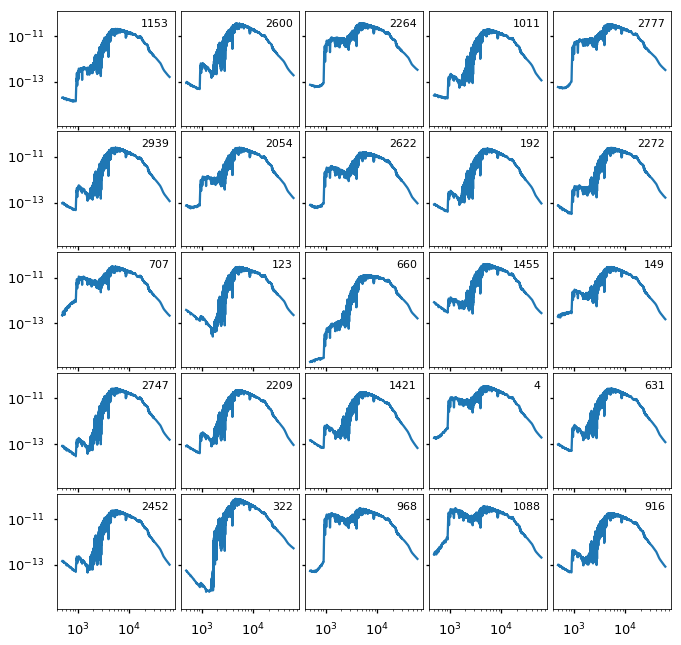

In [30]:
plot_subset()

### Finally, compare the colors of the templates to the data.

This test brings this analysis full circle.

In [31]:
def zgrid_colors():
    """Compute the colors of the templates on a fixed redshift grid."""
    from speclite import filters
    filt = filters.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1')
    
    zmin, zmax, dz = 0.2, 1.2, 0.1
    #zmin, zmax, dz = 0.0, 1.0, 0.1
    nz = np.round( (zmax - zmin) / dz ).astype('i2')
    print('Number of redshift points = {}'.format(nz))

    cc = dict(
        redshift = np.linspace(zmin, zmax, nz),
        gr = np.zeros( (nt, nz) ),
        rz = np.zeros( (nt, nz) ),
        zW1 = np.zeros( (nt, nz), )
    )    
    
    for iz, red in enumerate(cc['redshift']):
        zwave = wave.astype('float') * (1 + red)
        phot = filt.get_ab_maggies(flux, zwave, mask_invalid=False)
        cc['gr'][:, iz] = -2.5 * np.log10( phot['decam2014-g'] / phot['decam2014-r'] )
        cc['rz'][:, iz] = -2.5 * np.log10( phot['decam2014-r'] / phot['decam2014-z'] )
        cc['zW1'][:, iz] = -2.5 * np.log10( phot['decam2014-z'] / phot['wise2010-W1'] )
    
    return cc    

In [32]:
%time cc = zgrid_colors()

Number of redshift points = 10
CPU times: user 8.64 s, sys: 6.18 s, total: 14.8 s
Wall time: 14.9 s


In [33]:
grrange = (0.0, 3.0)
rzrange = (0.0, 2.5)
zW1range = (-1, 4)
ntspace = 20 # spacing between model curves

In [34]:
def grz(pngfile=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    hb = ax1.hexbin(cat['rzobs'], cat['grobs'], bins='log', 
                   mincnt=1, extent=rzrange+grrange,
                   C=cat['weight'], reduce_C_function=np.sum,                    
                   cmap=plt.cm.get_cmap('RdYlBu'))
    ax1.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax1.set_ylabel(r'$(g - r)_{\rm obs}$')
    ax1.set_xlim(rzrange)
    ax1.set_ylim(grrange)
    ax1.text(0.05, 0.9, 'Data', ha='left', va='bottom',
             transform=ax1.transAxes, fontsize=14)
    ax1.grid(True)

    #cb = fig.colorbar(hb, ax=ax1)
    #cb.set_label(r'log$_{10}$ (Number of Galaxies)')
    
    for tt in np.arange(0, nt, ntspace):
        ax2.plot(cc['rz'][tt, :], cc['gr'][tt, :], marker='s', 
                 markersize=5, ls='-', alpha=0.5)
        
    for tt in np.arange(0, nt, ntspace):
        ax2.scatter(cc['rz'][tt, 0], cc['gr'][tt, 0], marker='o', 
                   facecolors='none', s=80, edgecolors='k',
                   linewidth=2)
        
    ax2.text(0.1, 0.1, 'z=0.2', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    ax2.text(0.05, 0.9, 'Models (z=0.2-1.2, dz=0.1)', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    
    ax2.set_xlim(rzrange)
    ax2.set_ylim(grrange)
    ax2.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax2.set_ylabel(r'$(g - r)_{\rm obs}$')
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.grid(True)
    
    plt.subplots_adjust(wspace=0.05)
    
    if pngfile:
        fig.savefig(pngfile)

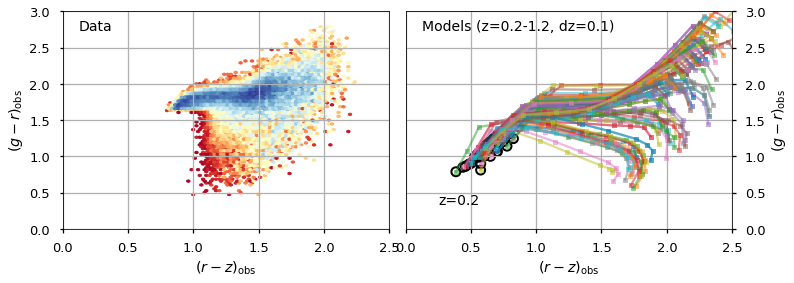

In [35]:
grz()

In [36]:
def rzW1(pngfile=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    hb = ax1.hexbin(cat['zW1obs'], cat['rzobs'], bins='log', 
                    mincnt=1, extent=rzrange+grrange,
                    C=cat['weight'], reduce_C_function=np.sum,                                        
                    cmap=plt.cm.get_cmap('RdYlBu'))

    ax1.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax1.set_xlabel(r'$(z - W1)_{\rm obs}$')
    ax1.set_xlim(zW1range)
    ax1.set_ylim(rzrange)
    ax1.text(0.05, 0.9, 'Data', ha='left', va='bottom',
             transform=ax1.transAxes, fontsize=14)
    ax1.grid(True)

    #cb = fig.colorbar(hb, ax=ax1)
    #cb.set_label(r'log$_{10}$ (Number of Galaxies)')
    
    for tt in np.arange(0, nt, ntspace):
        ax2.plot(cc['zW1'][tt, :], cc['rz'][tt, :], marker='s', 
                markersize=5, ls='-', alpha=0.5)
        
    for tt in np.arange(0, nt, ntspace):
        ax2.scatter(cc['zW1'][tt, 0], cc['rz'][tt, 0], marker='o', 
                   facecolors='none', s=80, edgecolors='k',
                   linewidth=2)
        
    ax2.text(0.03, 0.3, 'z=0.2', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    ax2.text(0.05, 0.9, 'Models (z=0.2-1.2, dz=0.1)', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    
    ax2.set_xlim(zW1range)
    ax2.set_ylim(rzrange)
    ax2.set_xlabel(r'$(z - W1)_{\rm obs}$')
    ax2.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.grid(True)
    
    plt.subplots_adjust(wspace=0.05)
    
    if pngfile:
        fig.savefig(pngfile)

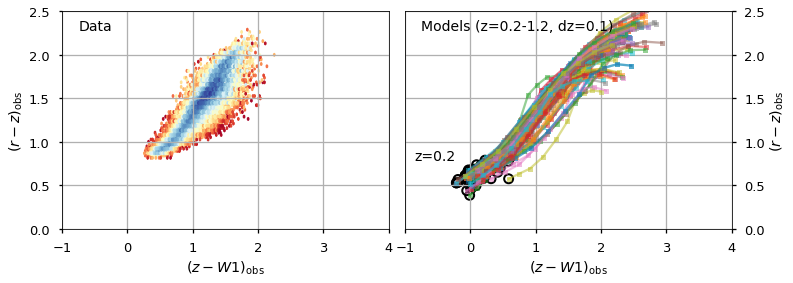

In [37]:
rzW1()